In [1]:
from datetime import datetime
import os
PATH = os.getcwd()
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
import networkx
from networkx import *
import sys
from pathlib import Path
p = (Path('.')).resolve()
if str(p) not in sys.path:
    sys.path.insert(0,str(p))

In [2]:
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
from seirsplus.parallel_run import *

## Parameter setup

### Social network

In [5]:
def get_network(N, p = 0.2):
    return {
    "G": Defer(gaussian_random_partition_graph,N, 20, 5, 0.5, 5/(N-20), directed=False),
    "N": N,
    "isolation groups": None,
    "p": p
    }

In [6]:
def random_graph(N,d, p =0.2):
    return {
        "G": Defer(fast_gnp_random_graph,N,d/N),
        "N": N,
        "p": p,
        "isolation groups": None
    }
        

In [3]:
def watts_strogatz(N, k, p):
    return {
        "G": Defer(watts_strogatz_graph,N, k, p),
        "N": N,
        "k": k,
        "p": p,
        "isolation groups": None
    }

### Infection parameters

In [4]:
def infect_params(N,R0_mean, R0_coeffvar= None, average_introductions_per_day = 0, single_intro_by =None,):
    latentPeriod_mean, latentPeriod_coeffvar = 3.0, 0.6
    SIGMA   = 1 / gamma_dist(latentPeriod_mean, latentPeriod_coeffvar, N)
    presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar = 2.2, 0.5
    LAMDA   = 1 / gamma_dist(presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar, N)
    symptomaticPeriod_mean, symptomaticPeriod_coeffvar = 4.0, 0.4
    GAMMA   = 1 / gamma_dist(symptomaticPeriod_mean, symptomaticPeriod_coeffvar, N)
    infectiousPeriod = 1/LAMDA + 1/GAMMA
    onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar = 11.0, 0.45
    ETA     = 1 / gamma_dist(onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar, N)
    hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar = 11.0, 0.45
    GAMMA_H = 1 / gamma_dist(hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar, N)
    hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar = 7.0, 0.45
    MU_H    = 1 / gamma_dist(hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar, N)
    PCT_FATALITY = 0.08
    PCT_HOSPITALIZED = 0.035
    P_GLOBALINTXN = 0.4
    if R0_coeffvar is None:
        R0_coeffvar = R0_mean/10
    R0 = gamma_dist(R0_mean, R0_coeffvar, N)
    BETA = 1/infectiousPeriod * R0
    return dict(beta=BETA, sigma=SIGMA, lamda=LAMDA, 
                   gamma=GAMMA, 
                   gamma_asym=GAMMA, eta=ETA, gamma_H=GAMMA_H, mu_H=MU_H, 
                a=PCT_ASYMPTOMATIC, h=PCT_HOSPITALIZED, f=PCT_FATALITY,              
                    isolation_time=14, 
               average_introductions_per_day = average_introductions_per_day,
               introduction_days = [] if single_intro_by is None else Defer(single_introduction,single_intro_by)) 

In [5]:
def infect_params_orig(N,R0, average_introductions_per_day = 0, single_intro_by =None, skip_pre= False, pct_symptomatic= 0, pre_symptomatic_period=3, infectious_period = 6.5, incubation_period = 5.2):
    ETA = 0
    MU_H    = 0 
    PCT_FATALITY = 0
    PCT_HOSPITALIZED = 0
    PCT_ASYMPTOMATIC = 1-pct_symptomatic
    BETA = R0/infectious_period
    if skip_pre:
        lamda = 0
        gamma = 1/infectious_period
    else:
        gamma = 1/pre_symptomatic_period
        lamda = 1/(infectious_period-pre_symptomatic_period)
    if not (single_intro_by is None):
        print("***",single_intro_by)
        introduction_days = Defer(single_introduction,single_intro_by)
    else: 
        introduction_days = []
    return dict(skip_pre=skip_pre,beta=BETA, sigma=1/incubation_period, lamda= lamda, 
                   gamma=gamma, 
                   gamma_asym=gamma, eta=ETA, gamma_H=gamma, mu_H=MU_H, 
                a=PCT_ASYMPTOMATIC, h=PCT_HOSPITALIZED, f=PCT_FATALITY,              
                    isolation_time=14, 
               average_introductions_per_day = average_introductions_per_day,
               introduction_days = introduction_days ) 

### Testing and intervention parameters

In [6]:
def run_params(N,frac_tested,frequency, testing_compliance_symptomatic=0):
    MAX_TIME = 105
    D=  dict(T = MAX_TIME,
    runTillEnd = False,
    intervention_start_pct_infected = 0/100,
    initI = 0, # initial number of infected people
    #testing_cadence                 = testing_cadence,      # how often to do testing (other than self-reporting symptomatics who can get tested any day)
    #cadence_testing_days = cadence_testing_days, # dictionary mapping testing_cadence to schedule (None =  default weekly/workday/etc..)
    pct_tested_per_day              = frac_tested,           # max daily test allotment defined as fraction of population size
    test_falseneg_rate              = 0.25,    # test false negative rate, will use fn rate that varies with disease time
    max_pct_tests_for_symptomatics  = 1,           # max percent of daily test allotment to use on self-reporting symptomatics
    max_pct_tests_for_traces        = 1,           # max percent of daily test allotment to use on contact traces
    random_testing_degree_bias      = 0,             # magnitude of degree bias in random selections for testing, none here

    pct_contacts_to_trace           = 0.0,           # percentage of primary cases' contacts that are traced
    tracing_lag                     = 2,             # number of cadence testing days between primary tests and tracing tests

    isolation_lag_symptomatic       = 1,             # number of days between onset of symptoms and self-isolation of symptomatics
    isolation_lag_positive          = 1,             # test turn-around time (tat): number of days between administration of test and isolation of positive cases
    isolation_lag_contact           = 0,             # number of days between a contact being traced and that contact self-isolating


    testing_compliance_symptomatic                  = testing_compliance_symptomatic,    
    testing_compliance_traced                       = 0,
    testing_compliance_random                       = 1,  # assume employee testing is mandatory, so 100% compliance

    tracing_compliance                              = 0.0,

    isolation_compliance_symptomatic_individual     = 0.0,
    isolation_compliance_symptomatic_groupmate      = 0.0,
    isolation_compliance_positive_individual        = 0.0,
    isolation_compliance_positive_groupmate         = 0.0,  # isolate teams with a positive member, but suppose 20% of employees are essential workforce
    isolation_compliance_positive_contact           = 0.0,
    isolation_compliance_positive_contactgroupmate  = 0.0,
    test_priority = 'last_tested',
    stopping_policy = Defer(stop_at_detection,lag=1), 
    budget_policy = scale_to_pool # fraction of tests is determined as fraction of eligible pool
    )
    if isinstance(frequency,str):
        D["testing_cadence"] = frequency
    else:
        D[("testing_cadence","cadence_testing_days","cadence_cycle_length")] = Defer(test_frequency,frequency)
    return D
    



## Set up experiment

In [27]:
# Watts_Strogatz

totals = [1,2,7,14,28,35,42]

Rs = [1.2, 1.6, 2, 2.4, 2.8,3.2,3.6,4.0,4.4,4.8]
torun = []
SKIP_PRE = True

INIT_INFECT = 1
INTRO_DAY = 0

# heat map budget

network = watts_strogatz(N=500, k=5, p=0.2)
for total in totals:
    for f in [1,total]: 
        for R in Rs: #numpy.linspace(1.0,4.0,15):
            N = network['N']
            D = {"N":N,
                 "frequency":f,
                 "experiment" : "varying_total",
                 "type": f"freq={f}/tot={total}/R={R}",
                 "R":R,
                 "total": total,
                 **network, 
                 **infect_params_orig(N,R,average_introductions_per_day = INTRO_DAY, single_intro_by=None, skip_pre=SKIP_PRE),
                 **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
                 "initE": INIT_INFECT,
                 "runTillEnd": INIT_INFECT>0,
                }
            torun.append(D)


# external infection

for total in [28]:
    for rate in [1/14,1/10,1/7,1/3.5,1/2]:
        for f in [1,7,28]:# [1]+totals:
            if total % f: continue
            for R in Rs: #numpy.linspace(1.0,4.0,15):
                N = network['N']
                D = {"N":N,
                     "frequency":f,
                     "experiment" : "external_introductions",
                     "type": f"freq={f}/tot={total}/R={R}/ext={rate}",
                     "R":R,
                     "total": total,
                     **network, 
                     **infect_params_orig(N,R,average_introductions_per_day = rate, single_intro_by=None, skip_pre=SKIP_PRE),
                     **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
                     "initI_asym": 0,
                     "runTillEnd": True
                    }
                torun.append(D)

realizations = 100

In [28]:
len(torun)*realizations

29000

## Run several experiments in parallel

In [29]:
os.chdir(PATH)
print(os.getcwd())
if not os.path.exists("data/"):
    os.makedirs("data")

timestamp = datetime.now().strftime('%Y%m%d_%H_%M_%S')
#datadir = f"data/heatmap_{timestamp}_{realizations}"
datadir = f"data/watts_strogatz"
if not os.path.exists("data/watts_strogatz"):
    os.makedirs("data/watts_strogatz")

torun_fname = datadir+"/torun.pickle"
save_to_file(torun,torun_fname)

/Users/antares/Desktop/seirsplus


In [30]:
print(datadir)
print(PATH)
#os.chdir("seirsplus")
print(torun_fname)
os.getcwd()

data/watts_strogatz
/Users/antares/Desktop/seirsplus
data/watts_strogatz/torun.pickle


'/Users/antares/Desktop/seirsplus'

In [31]:
%%time
os.chdir("seirsplus")
!python3 -m seirsplus.parallel_run --torun "/Users/antares/Desktop/seirsplus/$torun_fname" --realizations $realizations --savename "../$datadir/heatmap_data"
os.chdir(PATH)

Arguments:
torun : /Users/antares/Desktop/seirsplus/data/watts_strogatz/torun.pickle
realizations : 100
savename : ../data/watts_strogatz/heatmap_data
Loading torun
Loaded
Preparing list to run
Starting execution of 29000 runs
100%|███████████████████████████████████| 29000/29000 [4:28:19<00:00,  1.80it/s]
done
Saving csv
Saving split parts
Saving pickle 1
Done
CPU times: user 6min 4s, sys: 2min 6s, total: 8min 10s
Wall time: 4h 28min 36s


In [32]:
os.chdir(PATH)
os.getcwd()

'/Users/antares/Desktop/seirsplus'

In [33]:
os.chdir(PATH)
data = read_from_file(datadir+"/heatmap_data")

Loading chunk 1


In [34]:
len(data)

29000

In [35]:
data.experiment.unique()

array(['varying_total', 'external_introductions'], dtype=object)

In [36]:
def censor(df):
    return df[df['numPositive/sum']>0]

def restrict(df,total,R):
    return df[(df.total==total) & (df.R==R)]

def summarize(df, percentile=0.9):
    print(f"Total: {df.total.unique()} R: {df.R.unique()} min(numPositive/sum): {df['numPositive/sum'].min()}")
    print(f"Frequency: risk(mean),risk({percentile*100:.0f}%) | overall(mean),overall({percentile*100:.0f}%)")
    for i in sorted(df.frequency.unique()):
        s = df[df.frequency==i]
        t=s['numInfectious/average']
        u = s['overallInfected/last']
        print(f"{i:02d}:        {t.mean():.2f}, {t.quantile(percentile):.2f}           "+
               f"| {u.mean():.2f} , {u.quantile(percentile):.1f}                   "+
               f"| count={t.count()} ")
summarize(censor(restrict(data,total=28,R=2.0)))

Total: [28] R: [2.] min(numPositive/sum): 1.0
Frequency: risk(mean),risk(90%) | overall(mean),overall(90%)
01:        1.38, 2.57           | 11.58 , 24.0                   | count=559 
07:        1.46, 2.87           | 12.76 , 28.0                   | count=496 
28:        1.68, 3.17           | 13.83 , 28.0                   | count=549 


In [37]:
def summary(df,fields = ['numInfectious/average','overallInfected/last','time/last'], p=0.9):
    def top(x): return x.quantile(p) 
    print(f"Total: {df.total.unique()} R: {df.R.unique()} min(numPositive/sum): {df['numPositive/sum'].min()}")
    D =  {f: ['mean',top] for f in fields}
    D[fields[0]].insert(0,'count')
    return df.fillna(0).groupby('frequency')[fields].agg(D)

In [38]:
summary(censor(restrict(data,total=28,R=2.8)))

Total: [28] R: [2.8] min(numPositive/sum): 1.0


numInfectious/average                     overallInfected/last  \
                          count      mean       top                 mean   
frequency                                                                  
1                           569  1.621165  3.150987            14.648506   
7                           498  1.613931  3.113909            14.508032   
28                          565  2.036031  4.723409            20.217699   

                 time/last             
            top       mean        top  
frequency                              
1          33.0  25.654465  47.015048  
7          31.0  26.238606  51.383351  
28         48.6  26.966862  45.796569

In [39]:
data[(data.total==total) & (data.R==2.8)]

,time/last,N/last,numS/last,numE/last,numI_pre/last,numI_sym/last,numI_asym/last,numH/last,numR/last,numF/last,...,isolation_compliance_positive_contactgroupmate,test_priority,stopping_policy,budget_policy,verbose,testing_cadence,cadence_testing_days,cadence_cycle_length,model,initI_asym
84,34.576925,500.0,476.0,7.0,3.0,0.0,0.0,0.0,14.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7fa2c71ec280>,False,every 28,"{'every 28': [5, 33, 61, 89, 117, 145, 173, 20...",365,None,NaN
101,105.006260,500.0,499.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7fa2c71ec280>,False,every 1,"{'every 1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,...",365,None,NaN
135,30.031675,500.0,489.0,3.0,3.0,0.0,0.0,0.0,5.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7fa2c71ec280>,False,every 1,"{'every 1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,...",365,None,0.0
162,84.539947,500.0,490.0,2.0,4.0,0.0,0.0,0.0,4.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7fa2c71ec280>,False,every 7,"{'every 7': [6, 13, 20, 27, 34, 41, 48, 55, 62...",365,None,0.0
171,10.000000,500.0,499.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7fa2c71ec280>,False,every 1,"{'every 1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,...",365,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28964,22.295594,500.0,487.0,5.0,7.0,0.0,0.0,0.0,1.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7fa2c71ec280>,False,every 7,"{'every 7': [0, 7, 14, 21, 28, 35, 42, 49, 56,...",365,None,0.0
28972,41.258646,500.0,479.0,4.0,6.0,0.0,0.0,0.0,11.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7fa2c71ec280>,False,every 28,"{'every 28': [12, 40, 68, 96, 124, 152, 180, 2...",365,None,0.0
28973,37.148138,500.0,469.0,11.0,7.0,0.0,0.0,0.0,13.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7fa2c71ec280>,False,every 1,"{'every 1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,...",365,None,0.0
28990,6.153042,500.0,489.0,7.0,2.0,0.0,0.0,0.0,2.0,0.0,...,0.0,last_tested,<function stop_at_detection.<locals>.policy at...,<function scale_to_pool at 0x7fa2c71ec280>,False,every 28,"{'every 28': [5, 33, 61, 89, 117, 145, 173, 20...",365,None,0.0


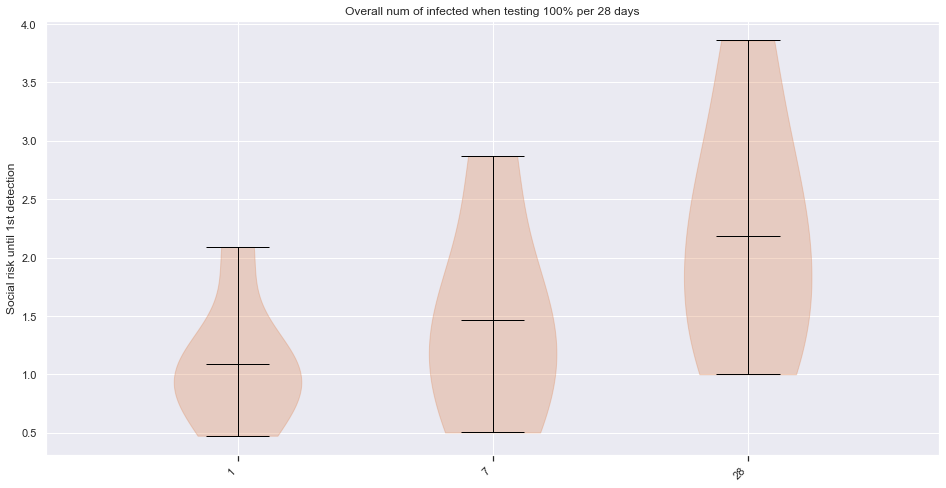

In [21]:
total = 28
show_violins(data[(data.total==total) & (data.R==2.8)],
             field = "numInfectious/average", 
             ylabel ="Social risk until 1st detection", 
             groupby="frequency", 
             title=f"Overall num of infected when testing 100% per {total} days")

In [18]:
def panels(data, yfield):
    daily = data[data.frequency==1]
    batch = data[data.frequency==data.total]
    panel1 = daily.groupby([yfield,"R"])["overallInfected/last"].mean().unstack()
    panel2 = batch.groupby([yfield,"R"])["overallInfected/last"].mean().unstack()
    panel3 = panel1/panel2*100
    return panel1,panel2,panel3

    

In [19]:
from matplotlib.colors import ListedColormap
def colormap(minval,midval,maxval, scale = "RdBu_r"):
    minval,midval,maxval = int(minval), int(midval), int(maxval)
    n = (maxval-minval)*10
    L = sns.color_palette(scale, n).as_hex()
    L1 = L[0:n//2:n//(2*(midval-minval))]
    L2 = L[n//2:n:n//(2*(maxval-midval))]
    return ListedColormap(L1+L2)
    
    
#greens = list(sns.color_palette("BuGn_d",(midval-minval)//2).as_hex())[::-1]
#L = greens + L1

#cmap_percentages = ListedColormap(L)
#L1 = sns.color_palette("RdBu_r", 2*MAX-10).as_hex()
#greens = list(reversed(sns.color_palette("BuGn_d",10).as_hex()))
#L = greens+L1[0:MAX:(MAX//10)] + L1[MAX:]
#from matplotlib.colors import ListedColormap
#cmap_numbers = ListedColormap(L)


In [20]:
from matplotlib.ticker import StrMethodFormatter 

def heatmap(data, yfield, ytitle, maxper = None, tight= False, maxval= 100):
    panel1,panel2,panel3 = panels(data,yfield)
    print(max(*panel1.values.flatten(),*panel2.values.flatten()))
    if maxval is None:
        maxval = max(*panel1.values.flatten(),*panel2.values.flatten())
    if not maxper:
        maxper = max(panel3.values.flatten())
    cmap_numbers = colormap(0,10,max(11,maxval))
    cmap_percentages = colormap(0,100,max(maxper,101), scale = 'RdYlGn_r')
    
    print(data.total.unique())
    

    size = 30
    titlesize = 40

    fig , axes = plt.subplots(1,3, sharex=True, sharey= True, figsize= (28,10))
    cbar_ax = fig.add_axes([-0.05, 0.15, .03, .7])
    #axes[0].title.set_text('28/4 vs baseline')
    #cmap = sns.diverging_palette(150, 275, sep=1,s=80, l=55, n=25)
    #fig.suptitle(f'Daily vs Batch testing - {statistic} overall infected individuals', fontsize=int(titlesize*1.1), color="blue")
    #fig.subplots_adjust(top=1)


    fmt = ".1f" 

    color = "white"
    axes[0].set_title("a) Cost with daily testing",loc="left",fontsize=int(titlesize))
    sns.heatmap(panel1,ax=axes[0],cbar=True, cbar_ax = cbar_ax ,  fmt=fmt, vmin=0,vmax= maxval, annot=False,cmap=cmap_numbers)# annot=True,fmt='.0f' ,cmap=cmap) # annot_kws={'color':color}

    axes[1].set_title('b) Cost with batch testing', loc='left',fontsize=int(titlesize))
    sns.heatmap(panel2,ax=axes[1],cbar=False, vmin=0,vmax= maxval, fmt=fmt,  annot= False,cmap=cmap_numbers)# annot=True,fmt='.0f', cmap=cmap)

    axes[2].set_title('c) Daily / Batch cost (%)', loc='left',fontsize=int(titlesize))
    sns.heatmap(panel3,ax=axes[2],cbar=True,  annot= False, fmt=fmt, vmin=0 ,vmax= max(100,maxper), cmap = cmap_percentages)# annot=True,fmt='.0f', cmap=cmap)
    #sns.heatmap(percent,ax=axes[2],vmin=0,vmax=125,cbar=True,  annot= True, fmt='.0f', cmap=cmap_percentages)# annot=True,fmt='.0f', cmap=cmap)

    cbar = axes[0].collections[0].colorbar
    cbar.ax.set_ylabel('# of individuals infected at detection',fontsize=size)
    cbar.ax.yaxis.set_ticks_position('left')
    cbar.ax.yaxis.set_label_position('left')
    cbar_ax.tick_params(axis='y',labelsize=size)
    cbar_ax = axes[2].collections[0].colorbar.ax
    #cbar_ax.set_ylabel('daily cost as % of batch cost',fontsize=20, rotation = 270)
    
    cbar_ax.text(4.5, 0.5, 'daily cost as % of batch cost', rotation=270, fontsize= size,
            verticalalignment='center', horizontalalignment='right', 
            transform=cbar_ax.transAxes)
    cbar_ax.tick_params(axis='y',labelsize=size)
    from fractions import Fraction

    def format_func(value, tick_number):
        introductions = sorted(data.average_introductions_per_day.unique())
        f = Fraction(introductions[tick_number]).limit_denominator(100)
        return fr"$\frac{{{f.numerator}}}{{{f.denominator}}}$"
    
    def format_func2(value,tick_number):
        budgets = sorted(data[yfield].unique())
        v = budgets[tick_number]
        return fr"$\frac{{1}}{{{v}}}$"
    
    


    for i in range(3):
        axes[i].set_ylabel('' if i else ytitle, fontsize=size)
        axes[i].set_xlabel('' if i!=1 else 'Reproductive number', fontsize=titlesize)
        axes[i].tick_params(axis='x', rotation=45, labelsize= size)
        axes[i].tick_params(axis='x', labelsize=size ) 
        axes[i].tick_params(axis='y',labelsize=size ) 


    if yfield == 'average_introductions_per_day':
        axes[0].yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    else:
        axes[0].yaxis.set_major_formatter(plt.FuncFormatter(format_func2))
        axes[0].tick_params(axis='y',rotation=0 ) 
    axes[0].tick_params(axis='y',labelsize= titlesize) 

    #fig.text(0.15,0,'* Dropping runs where all infected individuals recovered before detection', fontsize=12)
    cbar = axes[2].collections[0].colorbar
    #cbar.set_yticklabels([f"{int(i)}%" for i in cbar.get_ticks()]) # set ticks of your format
    #plt.show()


    if tight: fig.tight_layout() #rect=[0, 0, .9, 1])

In [43]:
data = data[data.R < 4.1]

49.12
[28]
<ipython-input-42-3b20e4bd7352>:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if tight: fig.tight_layout() #rect=[0, 0, .9, 1])


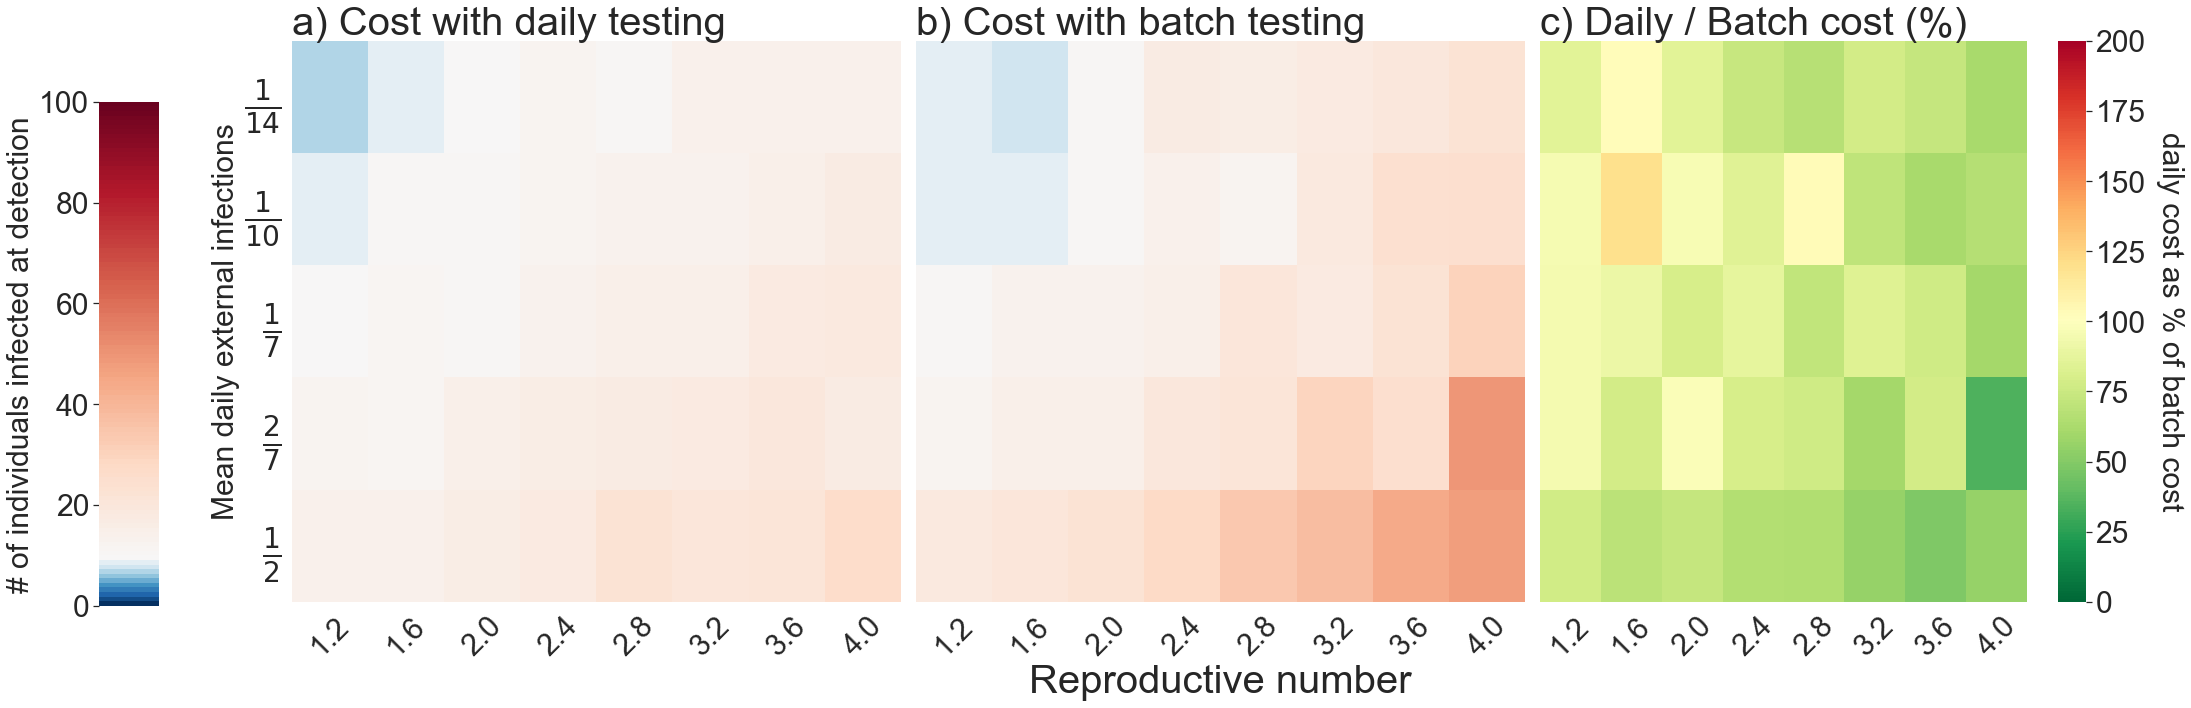

In [44]:
heatmap(data[data.experiment=='external_introductions'],'average_introductions_per_day','Mean daily external infections', maxper =200, tight = True)

33.74
[ 2  7 14 28 35 42]
<ipython-input-42-3b20e4bd7352>:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if tight: fig.tight_layout() #rect=[0, 0, .9, 1])


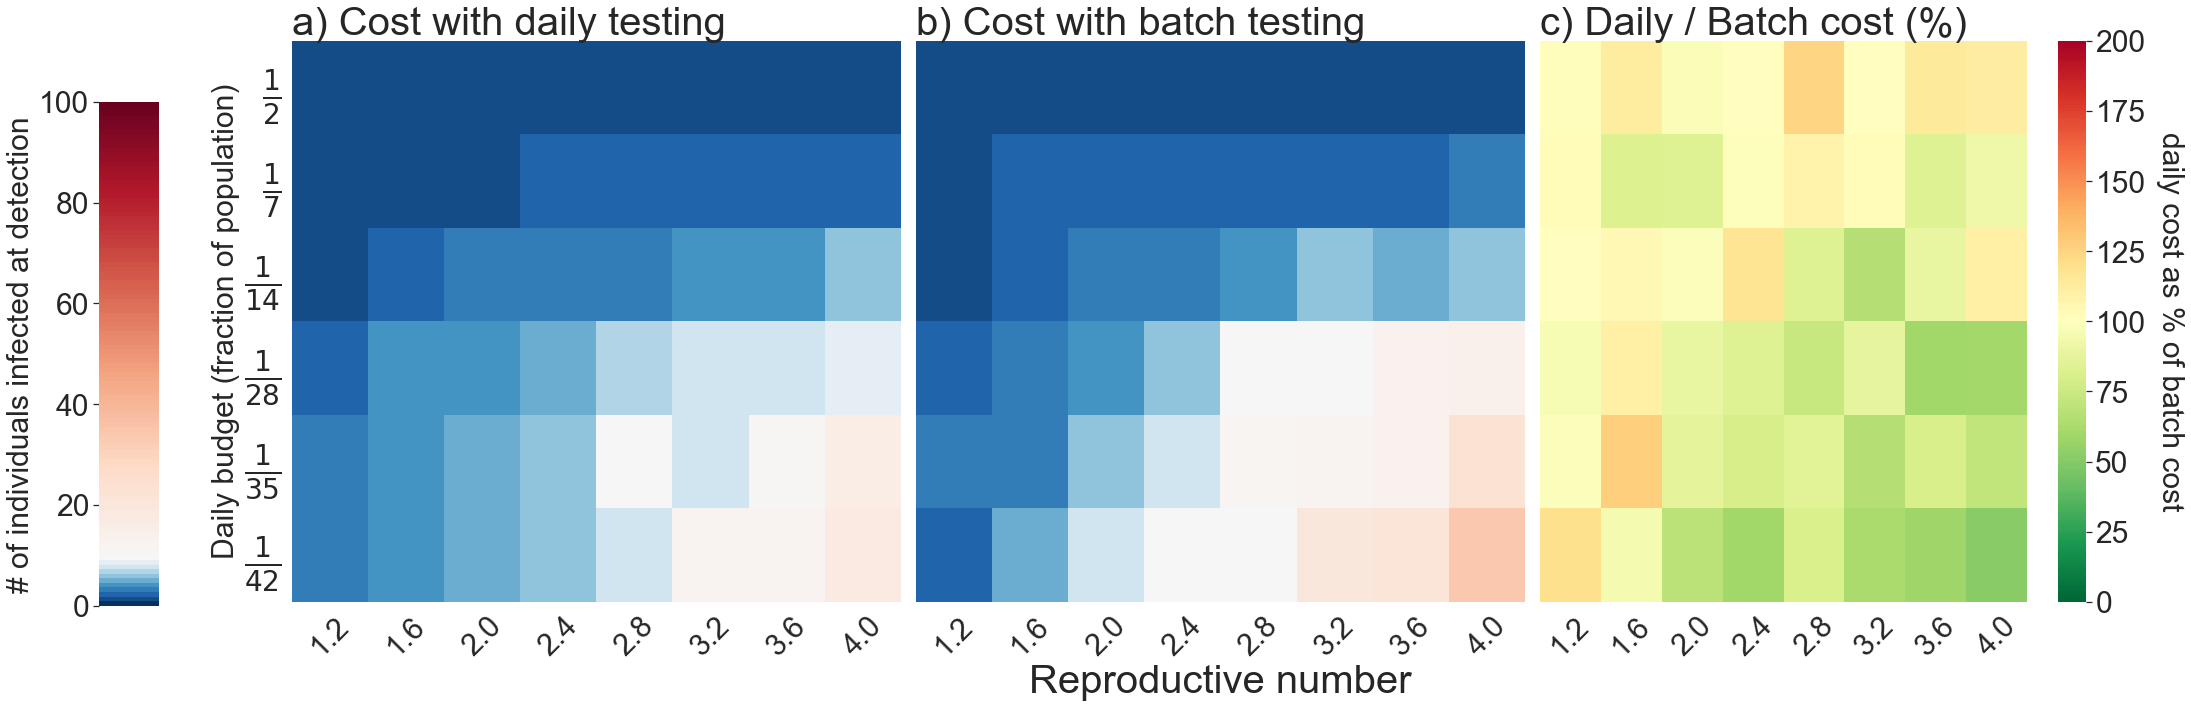

In [45]:
heatmap(data[(data.experiment=='varying_total') & (data.total>1)],'total','Daily budget (fraction of population)', maxper = 200, tight=True)

In [20]:
# Watts_Strogatz

totals = [1,2,7,14,28,35,42]

Rs = [1.2, 1.6, 2, 2.4, 2.8,3.2,3.6,4.0,4.4,4.8]
torun2 = []
SKIP_PRE = True

INIT_INFECT = 1
INTRO_DAY = 0

# heat map budget

network = watts_strogatz(N=500, k=10, p=0.2)
for total in totals:
    for f in [1,total]: 
        for R in Rs: #numpy.linspace(1.0,4.0,15):
            N = network['N']
            D = {"N":N,
                 "frequency":f,
                 "experiment" : "varying_total",
                 "type": f"freq={f}/tot={total}/R={R}",
                 "R":R,
                 "total": total,
                 **network, 
                 **infect_params_orig(N,R,average_introductions_per_day = INTRO_DAY, single_intro_by=None, skip_pre=SKIP_PRE),
                 **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
                 "initE": INIT_INFECT,
                 "runTillEnd": INIT_INFECT>0,
                }
            torun2.append(D)


# external infection

for total in [28]:
    for rate in [1/14,1/10,1/7,1/3.5,1/2]:
        for f in [1,7,28]:# [1]+totals:
            if total % f: continue
            for R in Rs: #numpy.linspace(1.0,4.0,15):
                N = network['N']
                D = {"N":N,
                     "frequency":f,
                     "experiment" : "external_introductions",
                     "type": f"freq={f}/tot={total}/R={R}/ext={rate}",
                     "R":R,
                     "total": total,
                     **network, 
                     **infect_params_orig(N,R,average_introductions_per_day = rate, single_intro_by=None, skip_pre=SKIP_PRE),
                     **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
                     "initI_asym": 0,
                     "runTillEnd": True
                    }
                torun2.append(D)

realizations = 100

In [22]:
os.chdir(PATH)
print(os.getcwd())
if not os.path.exists("data/"):
    os.makedirs("data")

datadir = f"data/watts_strogatz"
if not os.path.exists("data/watts_strogatz"):
    os.makedirs("data/watts_strogatz")

torun2_fname = datadir+"/torun2.pickle"
save_to_file(torun2,torun2_fname)

/Users/antares/Desktop/seirsplus


In [23]:
%%time
os.chdir("seirsplus")
!python3 -m seirsplus.parallel_run --torun "/Users/antares/Desktop/seirsplus/$torun2_fname" --realizations $realizations --savename "../$datadir/heatmap2_data"
os.chdir(PATH)

Arguments:
torun : /Users/antares/Desktop/seirsplus/data/watts_strogatz/torun2.pickle
realizations : 100
savename : ../data/watts_strogatz/heatmap2_data
Loading torun
Loaded
Preparing list to run
Starting execution of 29000 runs
100%|███████████████████████████████████| 29000/29000 [4:43:09<00:00,  1.71it/s]
done
Saving csv
Saving split parts
Saving pickle 1
Done
CPU times: user 6min 57s, sys: 2min 25s, total: 9min 23s
Wall time: 4h 43min 27s


In [13]:
os.chdir(PATH)
data2 = read_from_file(datadir+"/heatmap2_data")

Loading chunk 1


In [14]:
def censor(df):
    return df[df['numPositive/sum']>0]

def restrict(df,total,R):
    return df[(df.total==total) & (df.R==R)]

def summarize(df, percentile=0.9):
    print(f"Total: {df.total.unique()} R: {df.R.unique()} min(numPositive/sum): {df['numPositive/sum'].min()}")
    print(f"Frequency: risk(mean),risk({percentile*100:.0f}%) | overall(mean),overall({percentile*100:.0f}%)")
    for i in sorted(df.frequency.unique()):
        s = df[df.frequency==i]
        t=s['numInfectious/average']
        u = s['overallInfected/last']
        print(f"{i:02d}:        {t.mean():.2f}, {t.quantile(percentile):.2f}           "+
               f"| {u.mean():.2f} , {u.quantile(percentile):.1f}                   "+
               f"| count={t.count()} ")
               
summarize(censor(restrict(data2,total=28,R=2.0)))

Total: [28] R: [2.] min(numPositive/sum): 1.0
Frequency: risk(mean),risk(90%) | overall(mean),overall(90%)
01:        1.52, 2.94           | 13.23 , 28.9                   | count=562 
07:        1.49, 2.91           | 13.32 , 28.5                   | count=496 
28:        1.85, 4.23           | 16.95 , 42.0                   | count=553 


81.69
[28]
<ipython-input-17-3b20e4bd7352>:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if tight: fig.tight_layout() #rect=[0, 0, .9, 1])


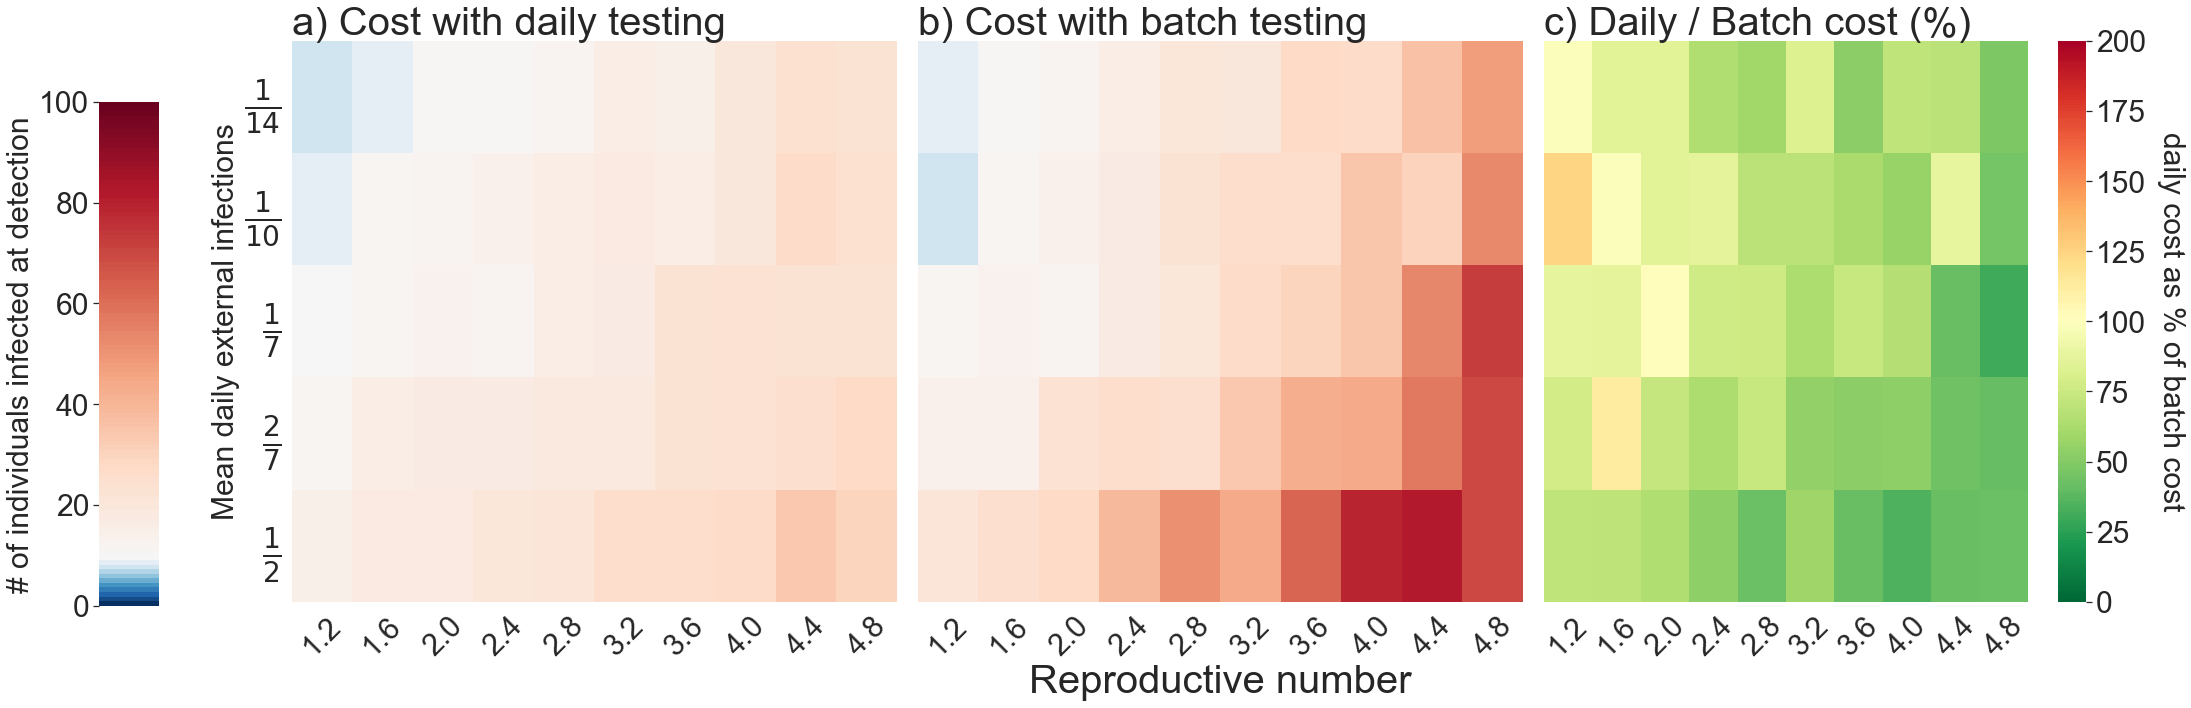

In [26]:
heatmap(data2[data2.experiment=='external_introductions'],'average_introductions_per_day','Mean daily external infections', maxper =200, tight = True)

81.26
[ 2  7 14 28 35 42]
<ipython-input-17-3b20e4bd7352>:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if tight: fig.tight_layout() #rect=[0, 0, .9, 1])


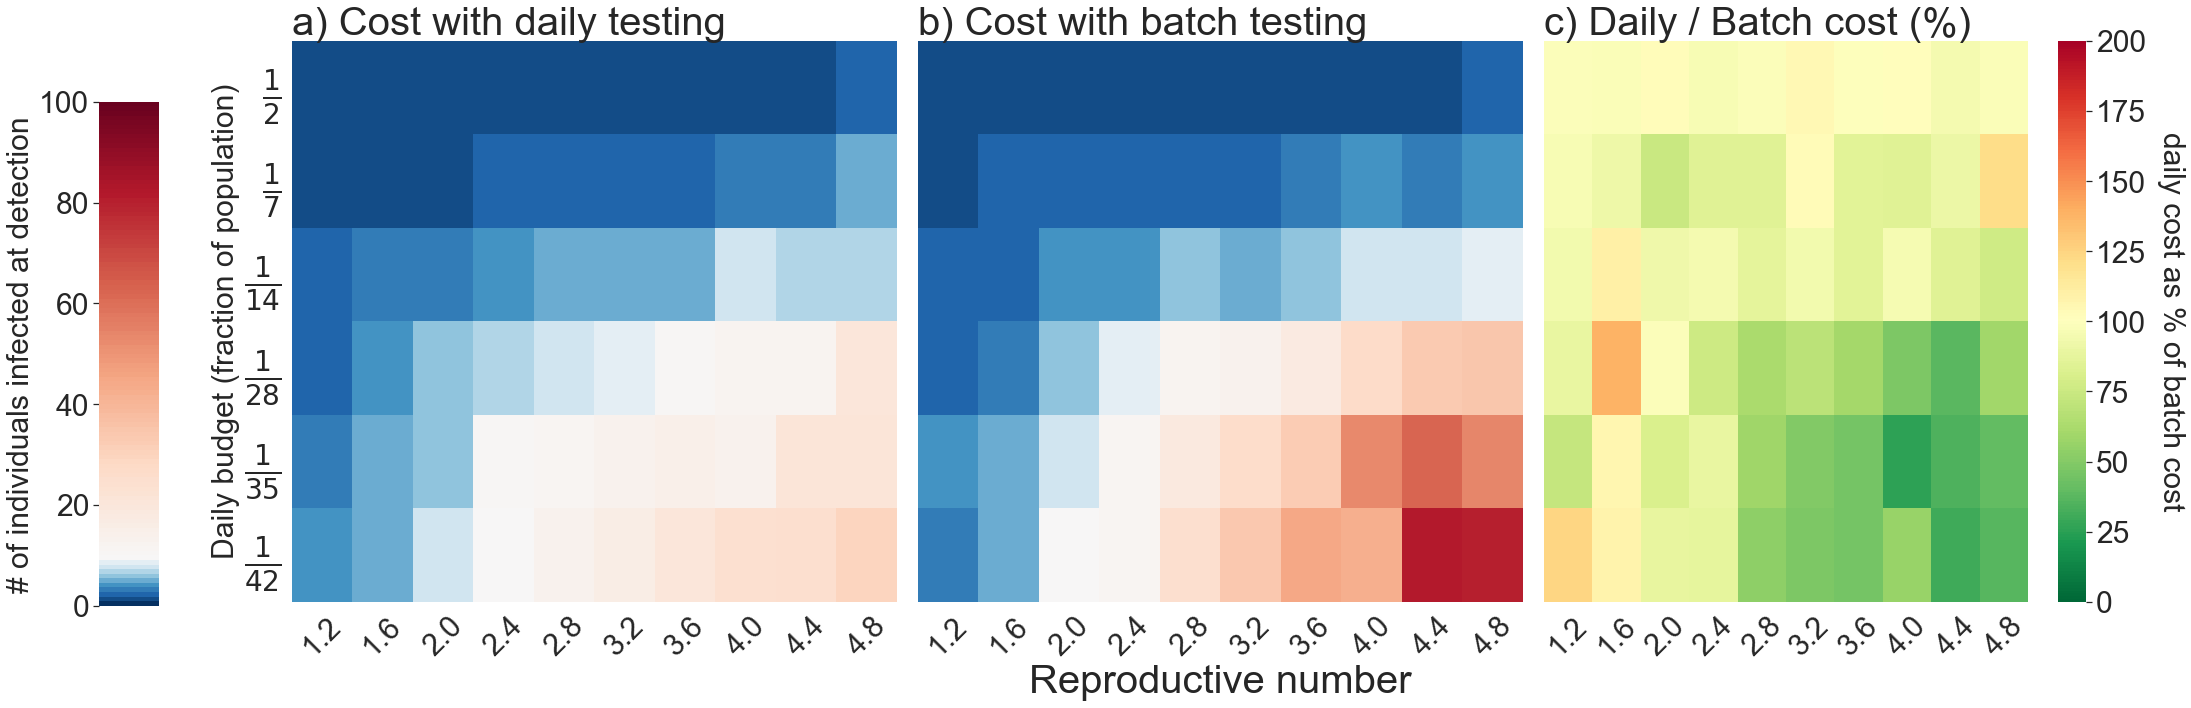

In [27]:
heatmap(data2[(data2.experiment=='varying_total') & (data2.total>1)],'total','Daily budget (fraction of population)', maxper = 200, tight=True)

In [7]:
# Watts_Strogatz

totals = [1,2,7,14,28,35,42]

Rs = [1.2, 1.6, 2, 2.4, 2.8,3.2,3.6,4.0,4.4,4.8]
torun3 = []
SKIP_PRE = True

INIT_INFECT = 1
INTRO_DAY = 0

# heat map budget

network = watts_strogatz(N=500, k=20, p=0.2)
for total in totals:
    for f in [1,total]: 
        for R in Rs: #numpy.linspace(1.0,4.0,15):
            N = network['N']
            D = {"N":N,
                 "frequency":f,
                 "experiment" : "varying_total",
                 "type": f"freq={f}/tot={total}/R={R}",
                 "R":R,
                 "total": total,
                 **network, 
                 **infect_params_orig(N,R,average_introductions_per_day = INTRO_DAY, single_intro_by=None, skip_pre=SKIP_PRE),
                 **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
                 "initE": INIT_INFECT,
                 "runTillEnd": INIT_INFECT>0,
                }
            torun3.append(D)


# external infection

for total in [28]:
    for rate in [1/14,1/10,1/7,1/3.5,1/2]:
        for f in [1,7,28]:# [1]+totals:
            if total % f: continue
            for R in Rs: #numpy.linspace(1.0,4.0,15):
                N = network['N']
                D = {"N":N,
                     "frequency":f,
                     "experiment" : "external_introductions",
                     "type": f"freq={f}/tot={total}/R={R}/ext={rate}",
                     "R":R,
                     "total": total,
                     **network, 
                     **infect_params_orig(N,R,average_introductions_per_day = rate, single_intro_by=None, skip_pre=SKIP_PRE),
                     **run_params(N,frac_tested=f/total,frequency=f, testing_compliance_symptomatic=0),
                     "initI_asym": 0,
                     "runTillEnd": True
                    }
                torun3.append(D)

realizations = 100

In [8]:
os.chdir(PATH)
print(os.getcwd())
if not os.path.exists("data/"):
    os.makedirs("data")

datadir = f"data/watts_strogatz"
if not os.path.exists("data/watts_strogatz"):
    os.makedirs("data/watts_strogatz")

torun3_fname = datadir+"/torun3.pickle"
save_to_file(torun3,torun3_fname)

/Users/antares/Desktop/seirsplus


In [9]:
%%time
os.chdir("seirsplus")
!python3 -m seirsplus.parallel_run --torun "/Users/antares/Desktop/seirsplus/$torun3_fname" --realizations $realizations --savename "../$datadir/heatmap3_data"
os.chdir(PATH)

Arguments:
torun : /Users/antares/Desktop/seirsplus/data/watts_strogatz/torun3.pickle
realizations : 100
savename : ../data/watts_strogatz/heatmap3_data
Loading torun
Loaded
Preparing list to run
Starting execution of 29000 runs
100%|███████████████████████████████████| 29000/29000 [4:54:38<00:00,  1.64it/s]
done
Saving csv
Saving split parts
Saving pickle 1
Done
CPU times: user 5min 40s, sys: 1min 49s, total: 7min 29s
Wall time: 4h 54min 53s


In [16]:
os.chdir(PATH)
data3 = read_from_file(datadir+"/heatmap3_data")
summarize(censor(restrict(data3,total=28,R=2.0)))

Loading chunk 1
Total: [28] R: [2.] min(numPositive/sum): 1.0
Frequency: risk(mean),risk(90%) | overall(mean),overall(90%)
01:        1.53, 2.87           | 13.61 , 30.0                   | count=564 
07:        1.50, 2.99           | 13.80 , 30.0                   | count=496 
28:        1.91, 4.10           | 17.89 , 44.7                   | count=554 


112.82
[28]
<ipython-input-20-3b20e4bd7352>:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if tight: fig.tight_layout() #rect=[0, 0, .9, 1])


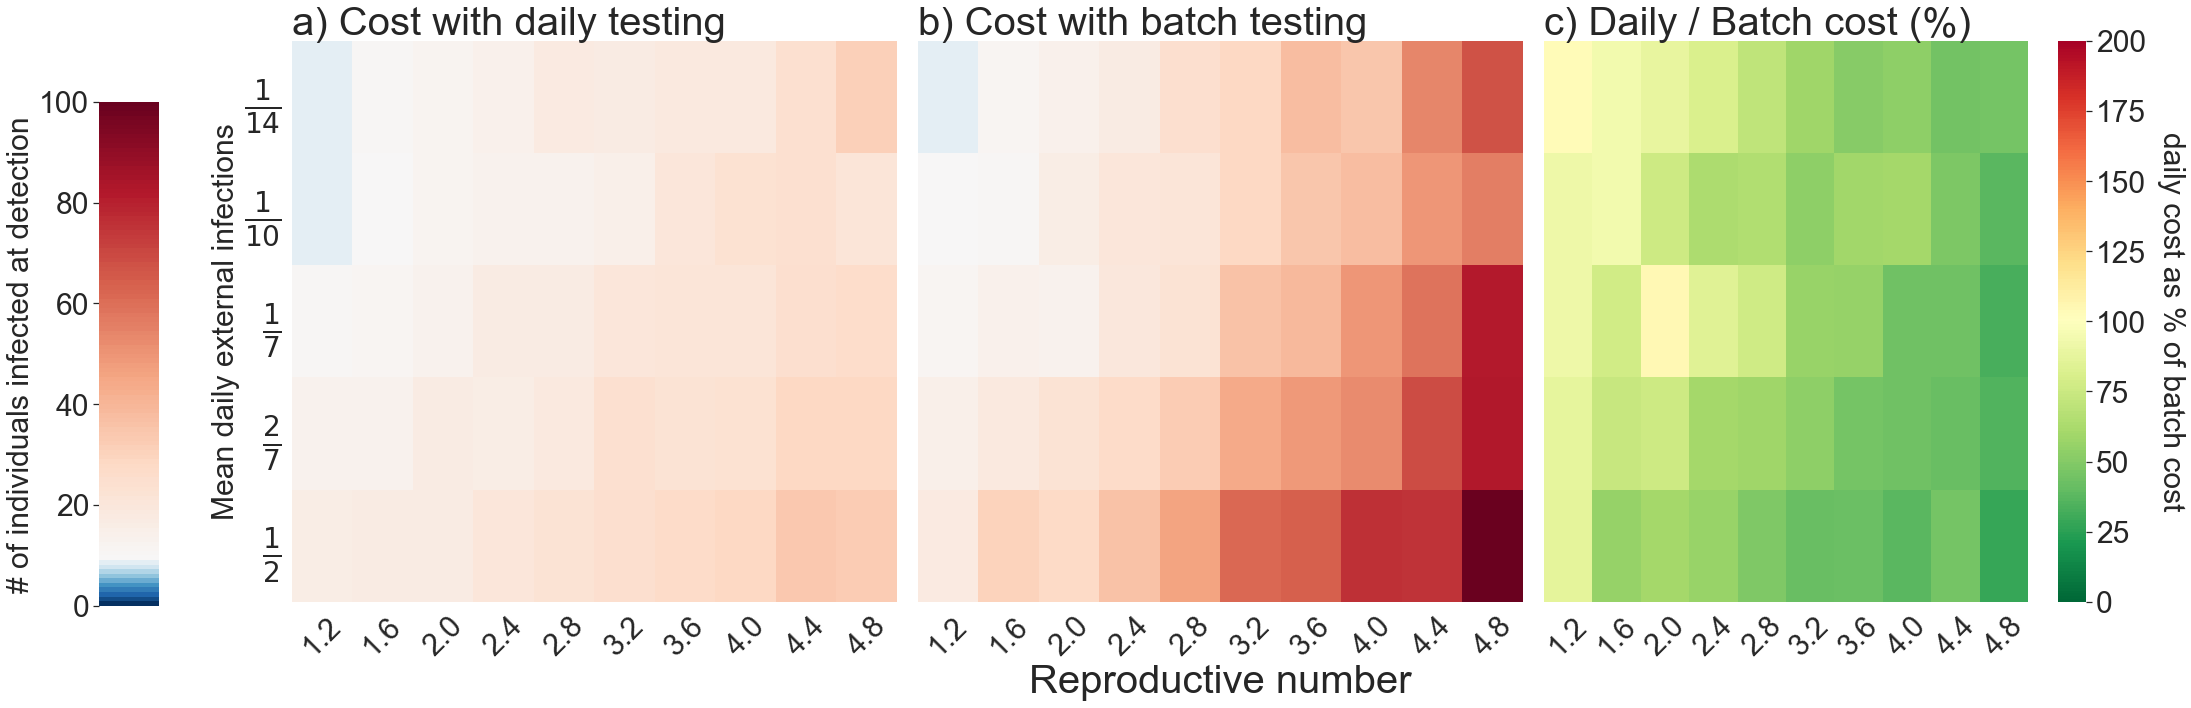

In [21]:
heatmap(data3[data3.experiment=='external_introductions'],'average_introductions_per_day','Mean daily external infections', maxper =200, tight = True)

86.16
[ 1  2  7 14 28 35 42]
<ipython-input-20-3b20e4bd7352>:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if tight: fig.tight_layout() #rect=[0, 0, .9, 1])


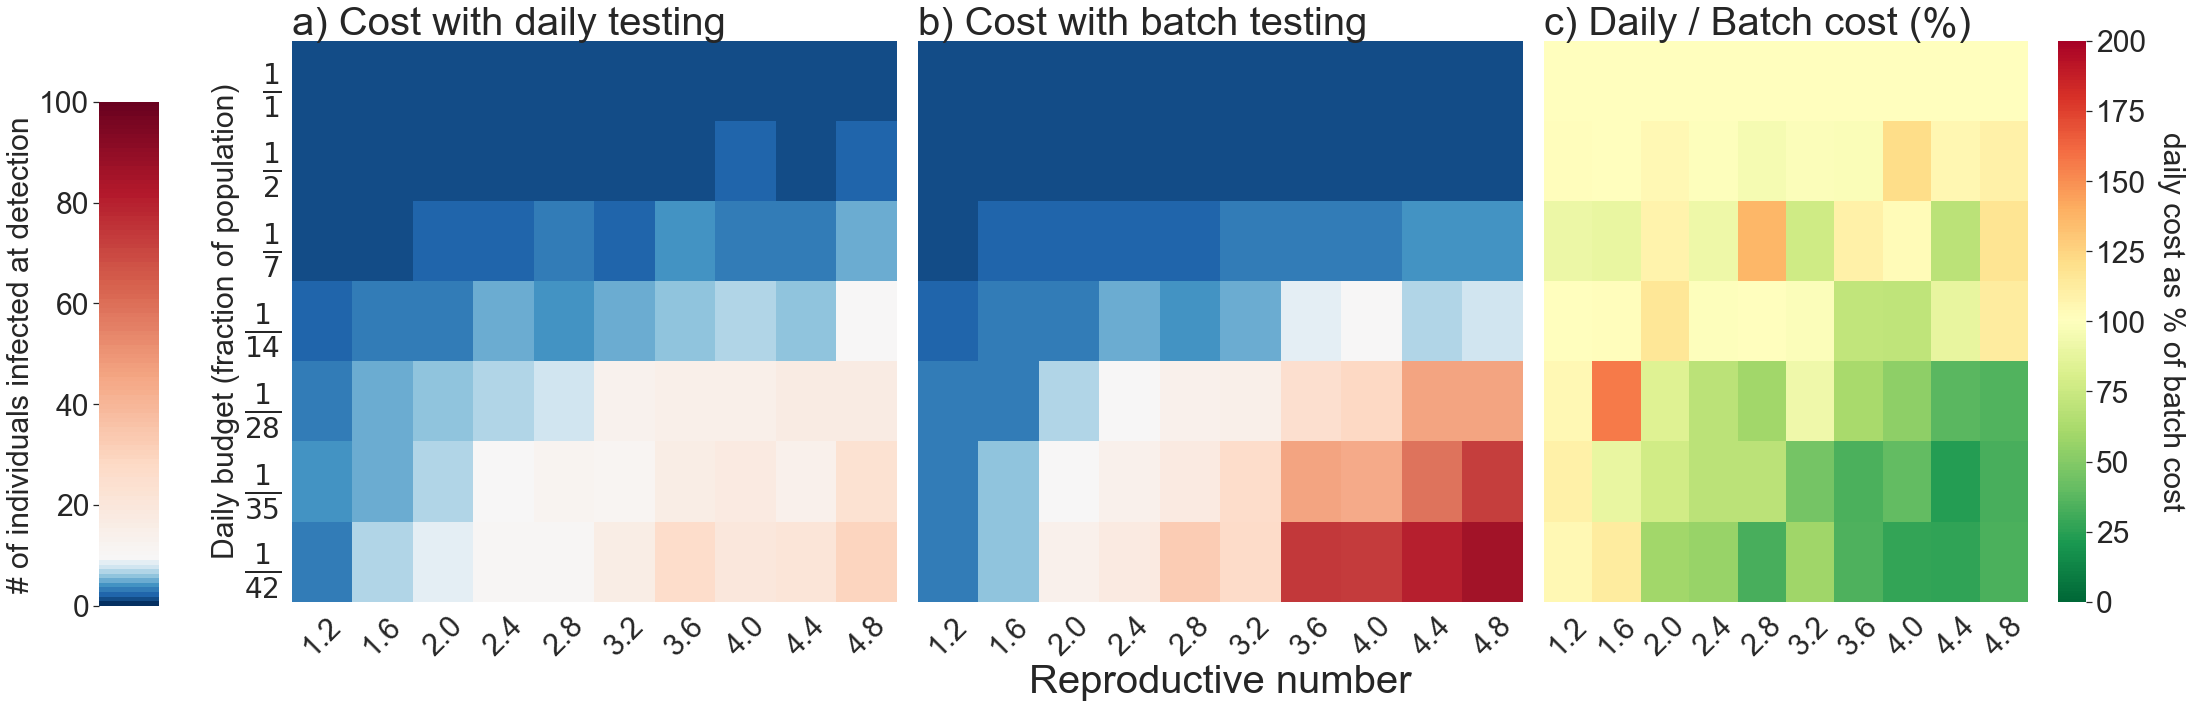

In [22]:
heatmap(data3[(data3.experiment=='varying_total') & (data2.total>1)],'total','Daily budget (fraction of population)', maxper = 200, tight=True)
